## Import Packages

In [1]:
#importing some useful packages
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
import time
import importlib
import vd_func as vd # vehicle detection functions library
importlib.reload(vd)
import alf_func as alf # advanced lane finding functions library
importlib.reload(alf)

<module 'alf_func' from 'C:\\Users\\diyer\\Desktop\\Courses\\SelfDrivingCar_ND\\Term_1\\Projects\\VehicleDetection_DI\\alf_func.py'>

In [2]:
left_info = alf.Fit_info()
right_info = alf.Fit_info()

with open("points.pickle","rb") as f:
    objpoints, imgpoints = pickle.load(f)  
    
frame = 0
calc_new_fit = True
mtx = []
dist = []

# Source and destination points for perspective warping
src = np.float32([[585., 460.], [203., 720.], [1126., 720.], [ 695., 460.]])
dst = np.float32([[320., 0.], [320., 720.], [960., 720.], [ 960., 0.]])

In [3]:
def find_lanes(img):
    
    global objpoints
    global imgpoints
    global src
    global dst
    global left_info
    global right_info 
    global frame
    global calc_new_fit
    global mtx
    global dist
    
    fit_found = False
    left_fit = []
    right_fit = []
    processed_image = img.copy()
    
    # Undistort the input image -  calculate camera matrix and distortion coefficients only once for the first frame 
    if frame == 0:
        undistorted, mtx, dist = alf.calc_undistort(img, objpoints, imgpoints)   
    else:
        undistorted = cv2.undistort(img, mtx, dist, None, mtx) 

    # Apply guassian blurring to smooth the image
    undistorted = alf.gaussian_blur(undistorted, kernel_size=5)

    # Apply binary thresholding on the channel S of HLS transformed image
    hls_s = alf.hls_select_thresh(undistorted, channel_sel = 's', thresh=(150, 255))

    # Apply binary thresholding on the gradient image obtained by applying Sobel x operator
    sobel_x = alf.abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(20,100))

    # Combine the two binary thresholded images
    combined = np.zeros_like(sobel_x)
    combined[(sobel_x == 1) | (hls_s == 1)] = 1
    combined = alf.region_of_interest(combined) 

    # Apply perspective transformation to warp and get birds eye view binary warped image
    binary_warped, M, Minv = alf.corners_unwarp(combined, mtx, dist, src, dst)    
    
    # Find left and right line fits only on the first frame
    if (frame == 0 or calc_new_fit == True):
        fit_found, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = alf.lf_histogram(binary_warped)
    else:
        # From the second frame onwards, use information from the previous average fits to calculate new fits
        fit_found, left_fit, right_fit, left_lane_inds, right_lane_inds = \
                                alf.apply_line_fit(binary_warped, left_info.coeff_avg, right_info.coeff_avg)
      
    if fit_found:          
        calc_new_fit = False
        
        if (frame >= 1):
            left_info.diffs = left_fit - left_info.coeff[-1]
            right_info.diffs = right_fit - right_info.coeff[-1]
            
        left_info.detected = fit_found
        # Store left fit coeffs into ring buffer
        left_info.coeff.append(left_fit)
        # Calculate the average fit of last 31 fits
        left_info.coeff_avg = robust_average(left_info.coeff, norm_order = 1) 

        right_info.detected = fit_found
        # Store right fit coeffs into ring buffer
        right_info.coeff.append(right_fit)  
        # Calculate the average fit of last 31 fits
        right_info.coeff_avg = robust_average(right_info.coeff, norm_order = 1)      
        
        if (frame == 0):
            calc_new_fit = False
    else:
        if (frame == 0):
            calc_new_fit = True
        calc_new_fit = False
        
    frame += 1 
    
    # Calculate left and right lane curvatures, and vehicle position, and 
    # draw the lanes on the undistorted image after unwarping    
    processed_image, left_curvature, right_curvature, vehicle_position, poly_corners = \
        alf.visualize_lanes_real_roads(undistorted, binary_warped, Minv, left_info.coeff_avg, right_info.coeff_avg)
    
    # Store lane curvatures and vehicle position into the ring buffer
    left_info.curvature.append(left_curvature)
    left_info.vehicle_position.append(vehicle_position)
    
    right_info.curvature.append(right_curvature)
    right_info.vehicle_position.append(vehicle_position)    
   
    return processed_image, undistorted, poly_corners

In [3]:
import pickle

with open('model_info_hybrid.pickle', 'rb') as handle:
    model_info = pickle.load(handle) 
    
bbox_buffer = vd.Box_info()

In [4]:
model_info

{'cell_per_block': 2,
 'cells_per_step': 2,
 'conv_color': 'RGB2LUV',
 'hist_bins': 32,
 'hist_range': (0, 256),
 'hog_channel': 0,
 'orient': 11,
 'pix_per_cell': 8,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_size': (16, 16),
 'svm_model': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'window': 64,
 'xgb_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
        max_depth=4, min_child_weight=1, missing=nan, n_estimators=150,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 'xgb_sel_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_byleve

In [5]:
# model_info = {'xgb_model': xgb_model, 'svm_model': svm_model,  
#      'xgb_selector': selection, 'xgb_sel_model': selection_model, 
#      'scaler': scaler, 'conv_color': conv_color,
#      'spatial_size': spatial_size, 'hist_bins': hist_bins, 'hist_range': (0, 256),     
#      'orient': orient, 'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 
#      'cells_per_step': 2, 'hog_channel': hog_channel,   
#      'xstartstop': (400, None), 'ystartstop': (400, 656), 'xy_window': (64, 64), 'xy_overlap': (0.5, 0.5),
#      'window': 64}


In [6]:
def get_hot_windows(img_un):
    
    global model_info
    
    # Apply sliding window with scale of 0.75 and cells_per_step = 3 (25% overlap)
    hot_windows_1 = vd.find_cars_hybrid(img_un, conv_color = model_info['conv_color'], 
                                xstart = model_info['xstartstop'][0], xstop = model_info['xstartstop'][1],
                                ystart = model_info['ystartstop'][0], ystop = model_info['ystartstop'][1],                    
                                scale = 0.75, window = 64, scaler = model_info['scaler'], 
                                svm_model = model_info['svm_model'], xgb_model = model_info['xgb_model'],
                                orient = model_info['orient'], pix_per_cell = model_info['pix_per_cell'], 
                                cell_per_block = model_info['cell_per_block'], cells_per_step = 3,
                                spatial_size = model_info['spatial_size'], hist_bins = model_info['hist_bins'],
                                hog_channel = model_info['hog_channel'])

    # Apply sliding window with scale of 1 and cells_per_step = 3 (25% overlap)
    hot_windows_2 = vd.find_cars_hybrid(img_un, conv_color = model_info['conv_color'], 
                                xstart = model_info['xstartstop'][0], xstop = model_info['xstartstop'][1],
                                ystart = model_info['ystartstop'][0], ystop = model_info['ystartstop'][1],                    
                                scale = 1.0, window = 64, scaler = model_info['scaler'], 
                                svm_model = model_info['svm_model'], xgb_model = model_info['xgb_model'],
                                orient = model_info['orient'], pix_per_cell = model_info['pix_per_cell'], 
                                cell_per_block = model_info['cell_per_block'], cells_per_step = 3,
                                spatial_size = model_info['spatial_size'], hist_bins = model_info['hist_bins'],
                                hog_channel = model_info['hog_channel'])
    
    # Apply sliding window with scale of 1.2 and cells_per_step = 3 (25% overlap)
    hot_windows_3 = vd.find_cars_hybrid(img_un, conv_color = model_info['conv_color'], 
                                xstart = model_info['xstartstop'][0], xstop = model_info['xstartstop'][1],
                                ystart = model_info['ystartstop'][0], ystop = model_info['ystartstop'][1],                    
                                scale = 1.2, window = 64, scaler = model_info['scaler'], 
                                svm_model = model_info['svm_model'], xgb_model = model_info['xgb_model'],
                                orient = model_info['orient'], pix_per_cell = model_info['pix_per_cell'], 
                                cell_per_block = model_info['cell_per_block'], cells_per_step = 3,
                                spatial_size = model_info['spatial_size'], hist_bins = model_info['hist_bins'],
                                hog_channel = model_info['hog_channel'])    

    # Concatenate the lists of hot windows
    hot_windows = hot_windows_1 + hot_windows_2 + hot_windows_3 
    
    return hot_windows

In [8]:
def process_image_smooth(img):       

    global bbox_buffer 
    
    # Find lanes
    img_wl, img_un, poly_corners = find_lanes(img)
    
    draw_image = np.copy(img_wl)
    # Normalize the undistorted image
    img_un = img_un.astype(np.float32)/255       
    
    # Get hot windows
    hot_windows = get_hot_windows(img_un)
    
    if (len(hot_windows) > 0):
        # Append hot windows to the ring buffer
        bbox_buffer.bboxes.append(hot_windows)
    
        # Calculate bounding boxes - filter false positive detections and average true positive detections
        bbox_buffer.bboxes_centroid, heatmap = vd.calc_centroid_box_with_filter(bbox_buffer.bboxes, img, poly=poly_corners, 
                                                                                thresh_lo=0.001, thresh_hi=0.15, shrink_rate=0.3, 
                                                                                dire='right')
        
        # Draw bounding boxes 
        draw_img = vd.draw_boxes(draw_image, bboxes=bbox_buffer.bboxes_centroid, color=(0, 0, 255), thick=6)   
    else:
        draw_img = np.copy(draw_image)        
    
    return draw_img

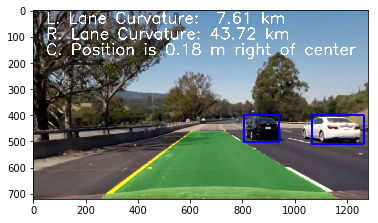

3.78


In [9]:
import time

t=time.time()
  
img = mpimg.imread('test_video_images/frame10.jpg')
draw_img = process_image(img)
plt.figure()
plt.imshow(draw_img)
plt.show()

t2 = time.time()
ttt = round(t2-t, 2)
print(ttt)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
output = 'test_videos/test_video_out_smooth.mp4'
# original_clip = VideoFileClip('test_videos/project_video.mp4').subclip(0,5) #subclip of the first 5 seconds
original_clip = VideoFileClip("test_videos/test_video.mp4")
processed_clip = original_clip.fl_image(process_image_smooth) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos/test_video_out_smooth.mp4
[MoviePy] Writing video test_videos/test_video_out_smooth.mp4


 97%|█████████▋| 38/39 [01:19<00:02,  2.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/test_video_out_smooth.mp4 

Wall time: 1min 20s


In [14]:
output = 'test_videos/project_video_out_smooth.mp4'
# original_clip = VideoFileClip('test_videos/project_video.mp4').subclip(0,12) #subclip of the first 5 seconds
original_clip = VideoFileClip('test_videos/project_video.mp4')
processed_clip = original_clip.fl_image(process_image_smooth) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos/project_video_out_smooth.mp4
[MoviePy] Writing video test_videos/project_video_out_smooth.mp4


100%|█████████▉| 1260/1261 [38:59<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/project_video_out_smooth.mp4 

Wall time: 38min 59s
